# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Fine-tune-optimization-so-it-works-in-edge-cases" data-toc-modified-id="Fine-tune-optimization-so-it-works-in-edge-cases-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fine-tune optimization so it works in edge cases</a></div><div class="lev2 toc-item"><a href="#estimating-hyperparameters" data-toc-modified-id="estimating-hyperparameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>estimating hyperparameters</a></div><div class="lev1 toc-item"><a href="#Example:-Lee" data-toc-modified-id="Example:-Lee-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example: Lee</a></div><div class="lev1 toc-item"><a href="#Iterate-over-simulation-settings" data-toc-modified-id="Iterate-over-simulation-settings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Iterate over simulation settings</a></div><div class="lev2 toc-item"><a href="#code:-sliding-window" data-toc-modified-id="code:-sliding-window-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>code: sliding window</a></div><div class="lev2 toc-item"><a href="#doing-it" data-toc-modified-id="doing-it-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>doing it</a></div><div class="lev1 toc-item"><a href="#Plotting-second-derivatives" data-toc-modified-id="Plotting-second-derivatives-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plotting second derivatives</a></div><div class="lev1 toc-item"><a href="#Scatter-Plot" data-toc-modified-id="Scatter-Plot-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scatter Plot</a></div><div class="lev1 toc-item"><a href="#Merged-plots" data-toc-modified-id="Merged-plots-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Merged plots</a></div><div class="lev1 toc-item"><a href="#understanding-drop-in-$\sigma/\ell$-in-Cate2" data-toc-modified-id="understanding-drop-in-$\sigma/\ell$-in-Cate2-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>understanding drop in <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-11-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03C3;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo>/</mo></mrow><mi>&amp;#x2113;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-71" style="width: 1.684em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.502em; height: 0px; font-size: 112%;"><span style="position: absolute; clip: rect(1.323em, 1001.47em, 2.415em, -1000em); top: -2.133em; left: 0em;"><span class="mrow" id="MathJax-Span-72"><span class="mi" id="MathJax-Span-73" style="font-family: NeoEulerMathJax_Main;">σ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="texatom" id="MathJax-Span-74"><span class="mrow" id="MathJax-Span-75"><span class="mo" id="MathJax-Span-76" style="font-family: NeoEulerMathJax_Main;">/</span></span></span><span class="mi" id="MathJax-Span-77" style="font-family: NeoEulerMathJax_Main;">ℓ</span></span><span style="display: inline-block; width: 0px; height: 2.133em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.249em; border-left: 0px solid; width: 0px; height: 1.089em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>σ</mi><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><mi>ℓ</mi></math></span></span><script type="math/tex" id="MathJax-Element-11">\sigma/\ell</script> in Cate2</a></div><div class="lev2 toc-item"><a href="#plotting-mLL-surface" data-toc-modified-id="plotting-mLL-surface-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>plotting mLL surface</a></div><div class="lev2 toc-item"><a href="#printing-some-mLL-diagnostics" data-toc-modified-id="printing-some-mLL-diagnostics-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>printing some mLL diagnostics</a></div>

In [1]:
using DataFrames
using GaussianProcesses
using Distributions
using GaussianProcesses: predict, get_params, get_optim_target, set_params!, update_mll!

using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [2]:
using NLopt

# Fine-tune optimization so it works in edge cases

In [3]:
function optimize_NLopt(gp::GP; noise::Bool=true, mean::Bool=true, kern::Bool=true, x_tol=1e-10, f_tol=1e-10)
    target = get_optim_target(gp, noise=noise, mean=mean, kern=kern)
    init_x = get_params(gp;  noise=noise, mean=mean, kern=kern)  # Initial hyperparameter values
    count = 0
    best_x = copy(init_x)
    best_y = Inf
    function myfunc(x::Vector, grad::Vector)
        if length(grad) > 0
            target.g!(x, grad)
        end

        count += 1
        y = target.f(x)
        if y < best_y
            best_y = y
            best_x[:] = x
        end
        @assert count < 100000
        return y
    end

    nparams = length(init_x)
    opt = NLopt.Opt(:LD_LBFGS, nparams)
    lower = Array(Float64, nparams)
    upper = Array(Float64, nparams)
    lower = init_x .- 1.0
    upper = init_x .+ 1.0
    NLopt.lower_bounds!(opt, lower)
    NLopt.upper_bounds!(opt, upper)
    NLopt.xtol_rel!(opt, x_tol)
    NLopt.ftol_rel!(opt, f_tol)
    NLopt.min_objective!(opt, myfunc)
    NLopt.maxeval!(opt, 10000)
    ret::Symbol=:unknown
    try
        (minf,minx,ret) = NLopt.optimize(opt, init_x)
    end
    while any(best_x.<(lower.+0.1)) | any(best_x .> (upper.-0.1))
        print("!")
        lower = best_x .- 1.0
        upper = best_x .+ 1.0
        NLopt.lower_bounds!(opt, lower)
        NLopt.upper_bounds!(opt, upper)
        try
            (minf,minx,ret) = NLopt.optimize(opt, best_x)
        catch err
            print("errLBFGS")
            print(err)
            break
        end
    end   
#     init_x[3] = 0.5 # log(ℓ)
#     init_x[4] = 0.0 # log(σ)
    lower = min.(init_x .- 1.0, best_x.-1.0)
    upper = max.(init_x .+ 1.0, best_x.+1.0)
    opt2 = NLopt.Opt(:LD_MMA, nparams)
    NLopt.lower_bounds!(opt2, lower)
    NLopt.upper_bounds!(opt2, upper)
    NLopt.xtol_rel!(opt2, x_tol)
    NLopt.ftol_rel!(opt2, f_tol)
    NLopt.min_objective!(opt2, myfunc)
    NLopt.maxeval!(opt2, 10000)
    try
        (minf,minx,ret) = NLopt.optimize(opt2, init_x)
    end
    while any(best_x.<(lower.+0.1)) | any(best_x .> (upper.-0.1))
        print("?")
        lower = best_x .- 1.0
        upper = best_x .+ 1.0
        NLopt.lower_bounds!(opt2, lower)
        NLopt.upper_bounds!(opt2, upper)
        try
            (minf,minx,ret) = NLopt.optimize(opt2, best_x)
        catch
            print("errMMA")
            print(err)
        end
    end
    GaussianProcesses.set_params!(gp, best_x; mean=mean,kern=kern,noise=noise)
    return best_y, best_x,ret,count
end

optimize_NLopt (generic function with 1 method)

## estimating hyperparameters

In [4]:
function est_hyperparams_NLopt(x::Vector{Float64}, y::Vector{Float64},
                         init_x::Vector{Float64})
    x.-=mean(x)
    y.-=mean(y)
    β0,β1=linreg(x,y)
    kern = SEIso(0.0, 0.0)
    meanf = MeanLin([β1])+MeanConst(β0)
    logNoise = log(1e-8)
    gp = GP(x', y, meanf, kern, logNoise)
    set_params!(kern, init_x)
    best_y, best_x,ret,count = optimize_NLopt(gp; mean=false, kern=true, noise=false, x_tol=1e-10, f_tol=1e-10)
    return kern, best_x
end

est_hyperparams_NLopt (generic function with 1 method)

In [5]:
using Iterators

In [6]:
function est_hyperparams_optim(x::Vector{Float64}, y::Vector{Float64},
                         init_x::Vector{Float64};
                         grid_width::Float64=2.0,
                         ngrid=10,
                         fitmean::Bool=true
                         )
    x.-=mean(x)
    y.-=mean(y)
    β0,β1=linreg(x,y)
    kern = SEIso(0.0, 0.0)
    meanf = MeanLin([β1])+MeanConst(β0)
    logNoise = log(1e-8)
    gp = GP(x', y, meanf, kern, logNoise)
    set_params!(kern, init_x[end-1:end])
    best_y = -Inf
    best_x = init_x
    grid = [linspace(x-grid_width,x+grid_width,ngrid) for x in init_x]
    hyper = similar(init_x)
    for hyper_tuple in product(grid...)
        for (i,x) in enumerate(hyper_tuple)
            hyper[i] = x
        end
        try
            set_params!(gp, hyper; mean=fitmean, kern=true, noise=false)
            update_mll!(gp)
        catch
            continue
        end
        y = gp.mLL
        if y > best_y
            best_y = y
            best_x[:] = hyper
        end
    end
    set_params!(gp, best_x; mean=fitmean, kern=true, noise=false)
    update_mll!(gp)
    try
        opt_out = GaussianProcesses.optimize!(gp; method=Optim.ConjugateGradient(), mean=fitmean, kern=true, noise=false, 
            options=Optim.Options(x_tol=1e-10, f_tol=0))
        best_x = Optim.minimizer(opt_out)
    catch err
        print("error in optimization: ")
        print(err)
    end 
    return kern, best_x
end

est_hyperparams_optim (generic function with 1 method)

In [7]:
function window_hyperparams(lower::Float64, upper::Float64, npoints::Int, 
        truth::Function, 
        init_x::Vector{Float64};
        grid_width::Float64=2.0,
        fitmean::Bool=true,
        ngrid::Int=10,
        )
    x=collect(linspace(lower,upper,npoints))
    y=truth.(x)
#     y[:] = y .+ rand(Normal(0,0.0001), length(x))
    return est_hyperparams_optim(x,y, init_x;grid_width=grid_width,fitmean=fitmean,ngrid=ngrid)
end

window_hyperparams (generic function with 1 method)

In [8]:
include("src/GeoRDD.jl")

GeoRDD

# Example: Lee

In [9]:
lee_left(x::Real) = 0.48 + 1.27 * x + 7.18*x^2 + 20.21*x^3 + 21.54*x^4 + 7.33*x^5
lee_right(x::Real) = 0.52 + 0.84 * x - 3.00*x^2 + 7.99*x^3  - 9.01*x^4 + 3.56*x^5
lee_truth(x::Real) = x<zero(x) ? lee_left(x) : lee_right(x)

lee_truth (generic function with 1 method)

In [10]:
xx=linspace(-1.0,1.0,500);

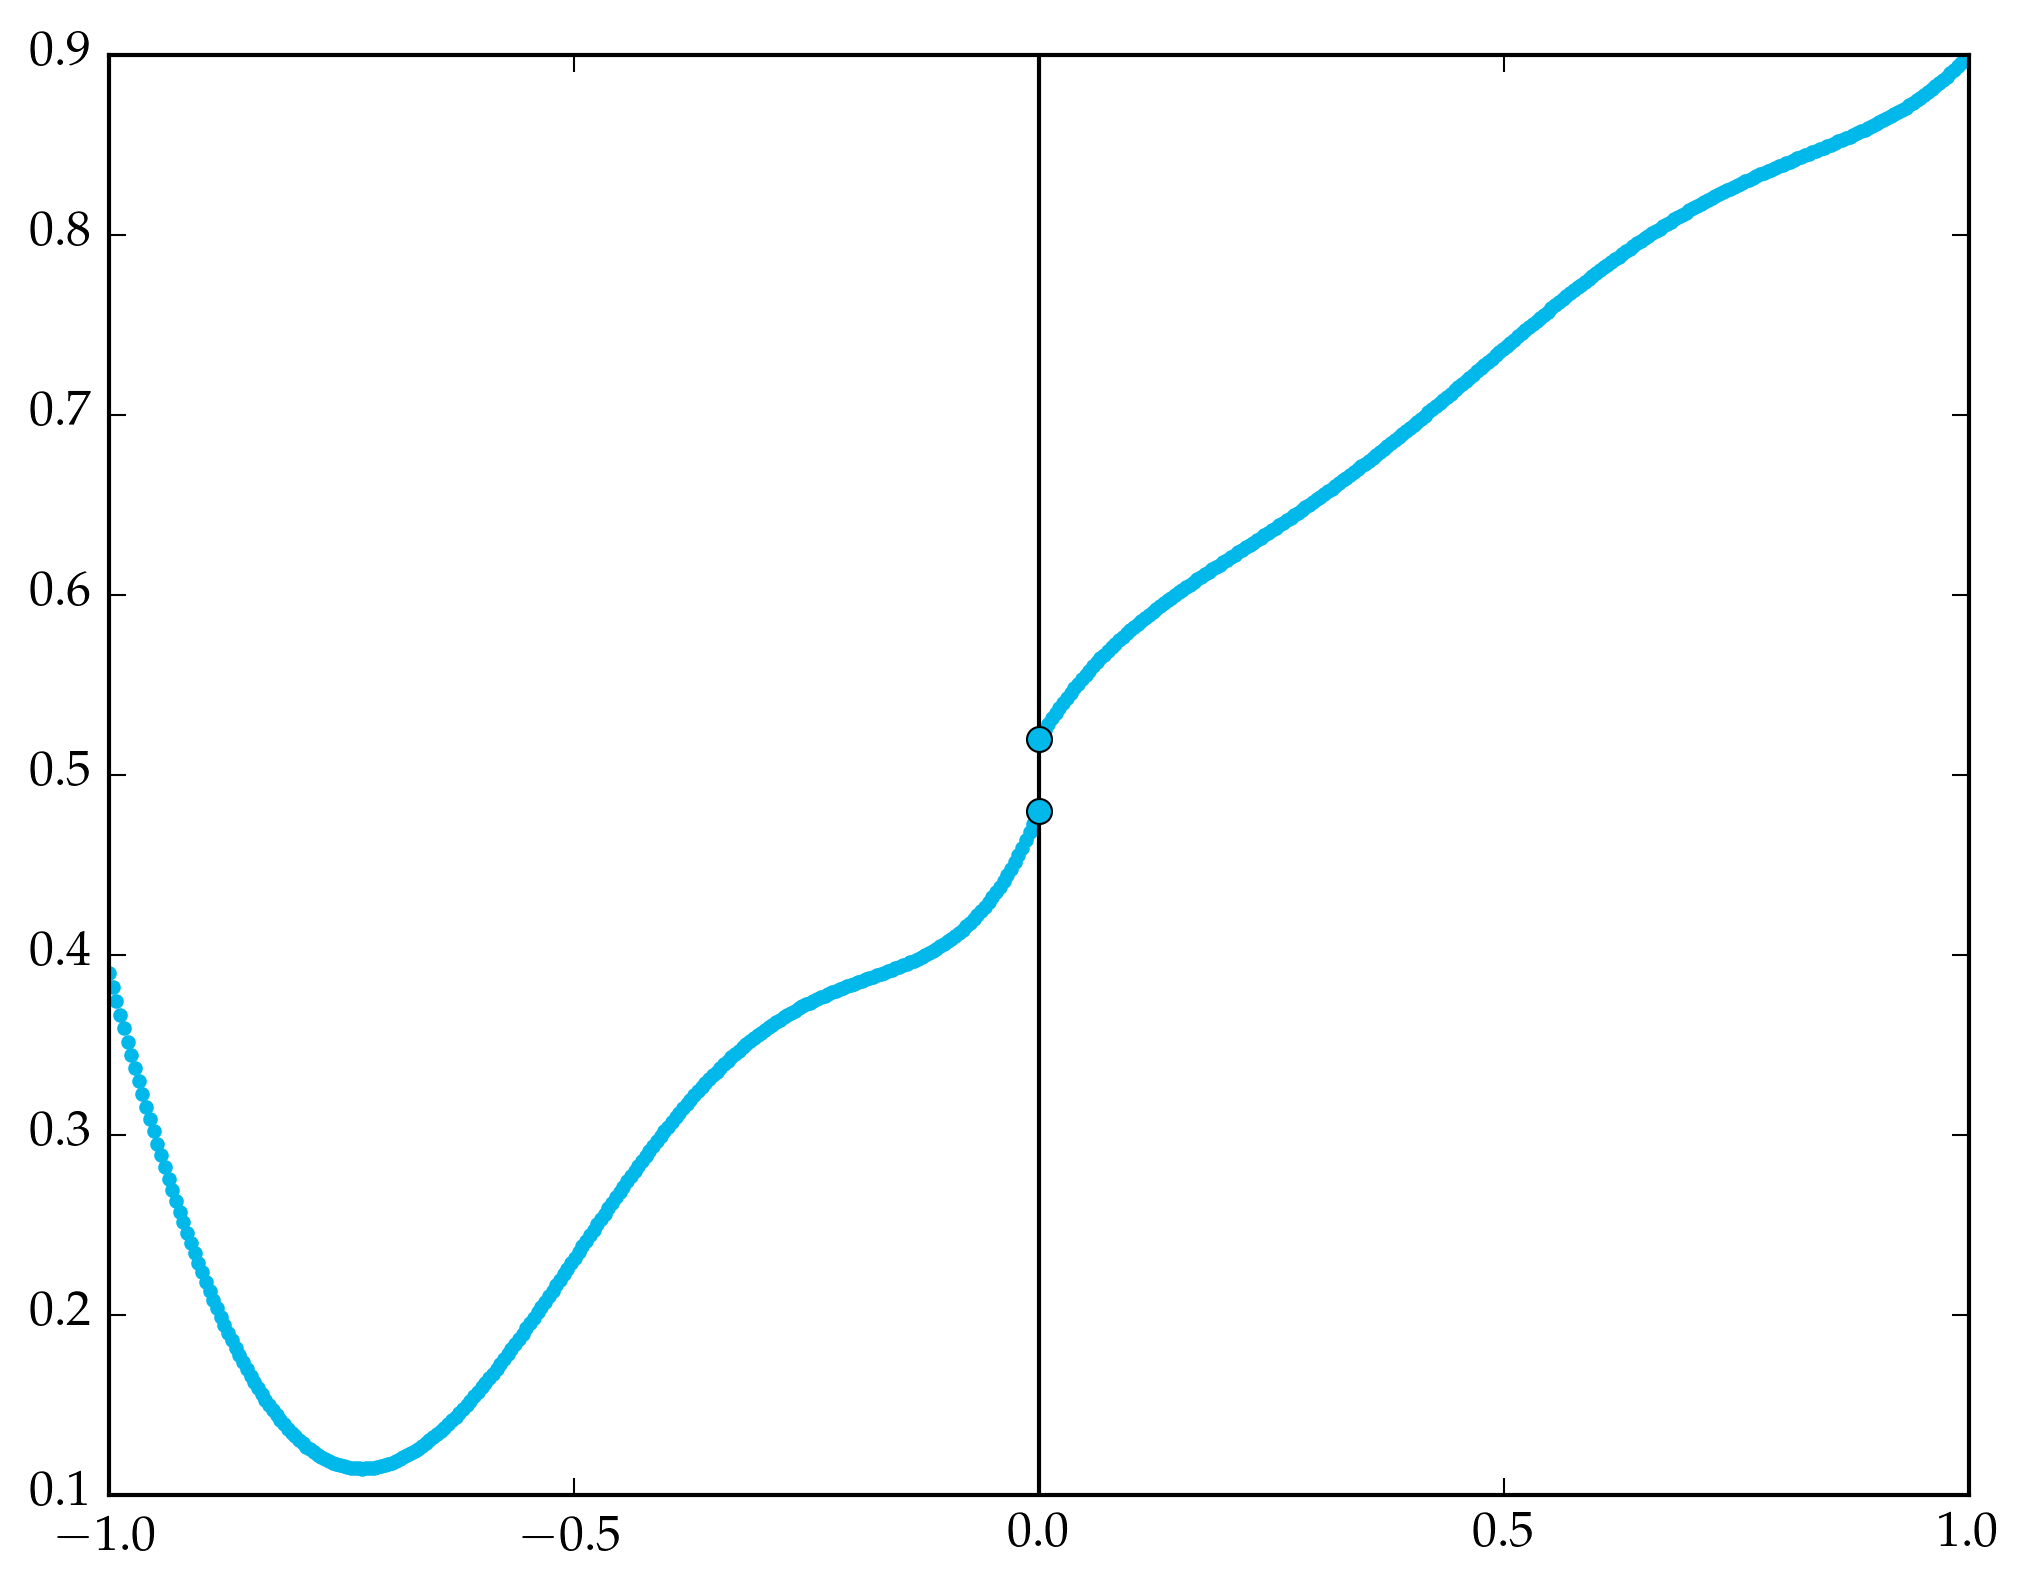

In [11]:
plt.plot(xx, lee_truth.(xx), ".", color="#00B8EA", linewidth=2, label="truth")
plt.axvline(0.0, color="black")
plt.plot(0.0, lee_left(0.0), "o", color="#00B8EA")
plt.plot(0.0, lee_right(0.0), "o", color="#00B8EA")
;

In [12]:
x=collect(linspace(-1.0,-0.7,100))
y=lee_truth.(x)
fitted_k, fitted_x = est_hyperparams_NLopt(x,y, [0.0,0.0])

(Type: GaussianProcesses.SEIso, Params: [-0.879276,-0.731704]
,[-0.879276,-0.731704])

In [13]:
@time fitted_k, fitted_x = est_hyperparams_NLopt(x,y, [0.0,0.0])

  0.135276 seconds (61.05 k allocations: 2.501 MB)


(Type: GaussianProcesses.SEIso, Params: [-0.87927,-0.731661]
,[-0.87927,-0.731661])

In [14]:
est_hyperparams_optim(x,y, [0.0,0.0])
@time est_hyperparams_optim(x,y, [0.0,0.0])

  0.113236 seconds (91.43 k allocations: 4.351 MB)


(Type: GaussianProcesses.SEIso, Params: [-0.959306,-1.10301]
,[-0.511888,0.407351,-0.959306,-1.10301])

In [15]:
est_hyperparams_optim(x,y, [0.0,0.0])
@time est_hyperparams_optim(x,y, [0.0,0.0]; fitmean=false)

  0.103229 seconds (98.38 k allocations: 3.980 MB)


(Type: GaussianProcesses.SEIso, Params: [-0.879288,-0.731699]
,[-0.879288,-0.731699])

In [16]:
@printf("σ_GP: %.10f\n", √fitted_k.σ2)
@printf("ℓ: %.10f", √fitted_k.ℓ2)

σ_GP: 0.4811093181
ℓ: 0.4150856238

In [17]:
fitted_k, fitted_x = window_hyperparams(-1.0, -0.8, 200, 
    lee_left, [0.0,0.0]; fitmean=false)

(Type: GaussianProcesses.SEIso, Params: [-0.911763,-0.862959]
,[-0.911763,-0.862959])

In [18]:
@printf("σ_GP: %.10f\n", √fitted_k.σ2)
@printf("ℓ: %.10f", √fitted_k.ℓ2)

σ_GP: 0.4219118898
ℓ: 0.4018152877

# Iterate over simulation settings

In [19]:
type SimulationSetting
    left::Function
    right::Function
    name::String
end

In [20]:
lee_left(x::Real) = 0.48 + 1.27 * x + 7.18*x^2 + 20.21*x^3 + 21.54*x^4 + 7.33*x^5
lee_right(x::Real) = 0.52 + 0.84 * x - 3.00*x^2 + 7.99*x^3  - 9.01*x^4 + 3.56*x^5
lee = SimulationSetting(lee_left, lee_right, "Lee")

quad_left(x::Real) = 3*x^2
quad_right(x::Real) = 4*x^2
quad = SimulationSetting(quad_left, quad_right, "Quad")

cubic_left(x::Real) = 3*x^3
cubic_right(x::Real) = 4*x^3
cubic = SimulationSetting(cubic_left, cubic_right, "Cubic")

cate1_left(x::Real) = 0.42 + 0.84 * x - 3.00 * x^2 + 7.99 * x^3 - 9.01 * x^4 + 3.56 * x^5
cate1_right(x::Real) = 0.1+cate1_left(x)
cate1 = SimulationSetting(cate1_left, cate1_right, "Cate1")

cate2_left(x::Real) = 0.42 + 0.84 * x + 7.99 * x^3 - 9.01 * x^4 + 3.56 * x^5
cate2_right(x::Real) = 0.1+cate2_left(x)
cate2 = SimulationSetting(cate2_left, cate2_right, "Cate2")

ludwig_left(x::Real) = 3.71 + 2.30*x + 3.28*x^2 + 1.45*x^3 + 0.23*x^4 + 0.03*x^5
ludwig_right(x::Real) = 0.36 + 18.49*x - 54.81*x^2 + 74.30*x^3 - 45.02*x^4 + 9.83*x^5
ludwig = SimulationSetting(ludwig_left, ludwig_right, "Ludwig")

curvature_left(x::Real) = 0.48 + 1.27 * x - 0.5*7.18*x^2 + 0.7*20.21*x^3 + 1.1*21.54*x^4 + 1.5*7.33*x^5
curvature_right(x::Real) = 0.52 + 0.84 * x - 0.1*3.00*x^2 - 0.3*7.99*x^3  - 0.1*9.01*x^4 + 3.56*x^5
curvature = SimulationSetting(curvature_left, curvature_right, "Curvature")

settings = SimulationSetting[lee, quad, cubic, cate1, cate2, ludwig, curvature]

7-element Array{SimulationSetting,1}:
 SimulationSetting(lee_left,lee_right,"Lee")                  
 SimulationSetting(quad_left,quad_right,"Quad")               
 SimulationSetting(cubic_left,cubic_right,"Cubic")            
 SimulationSetting(cate1_left,cate1_right,"Cate1")            
 SimulationSetting(cate2_left,cate2_right,"Cate2")            
 SimulationSetting(ludwig_left,ludwig_right,"Ludwig")         
 SimulationSetting(curvature_left,curvature_right,"Curvature")

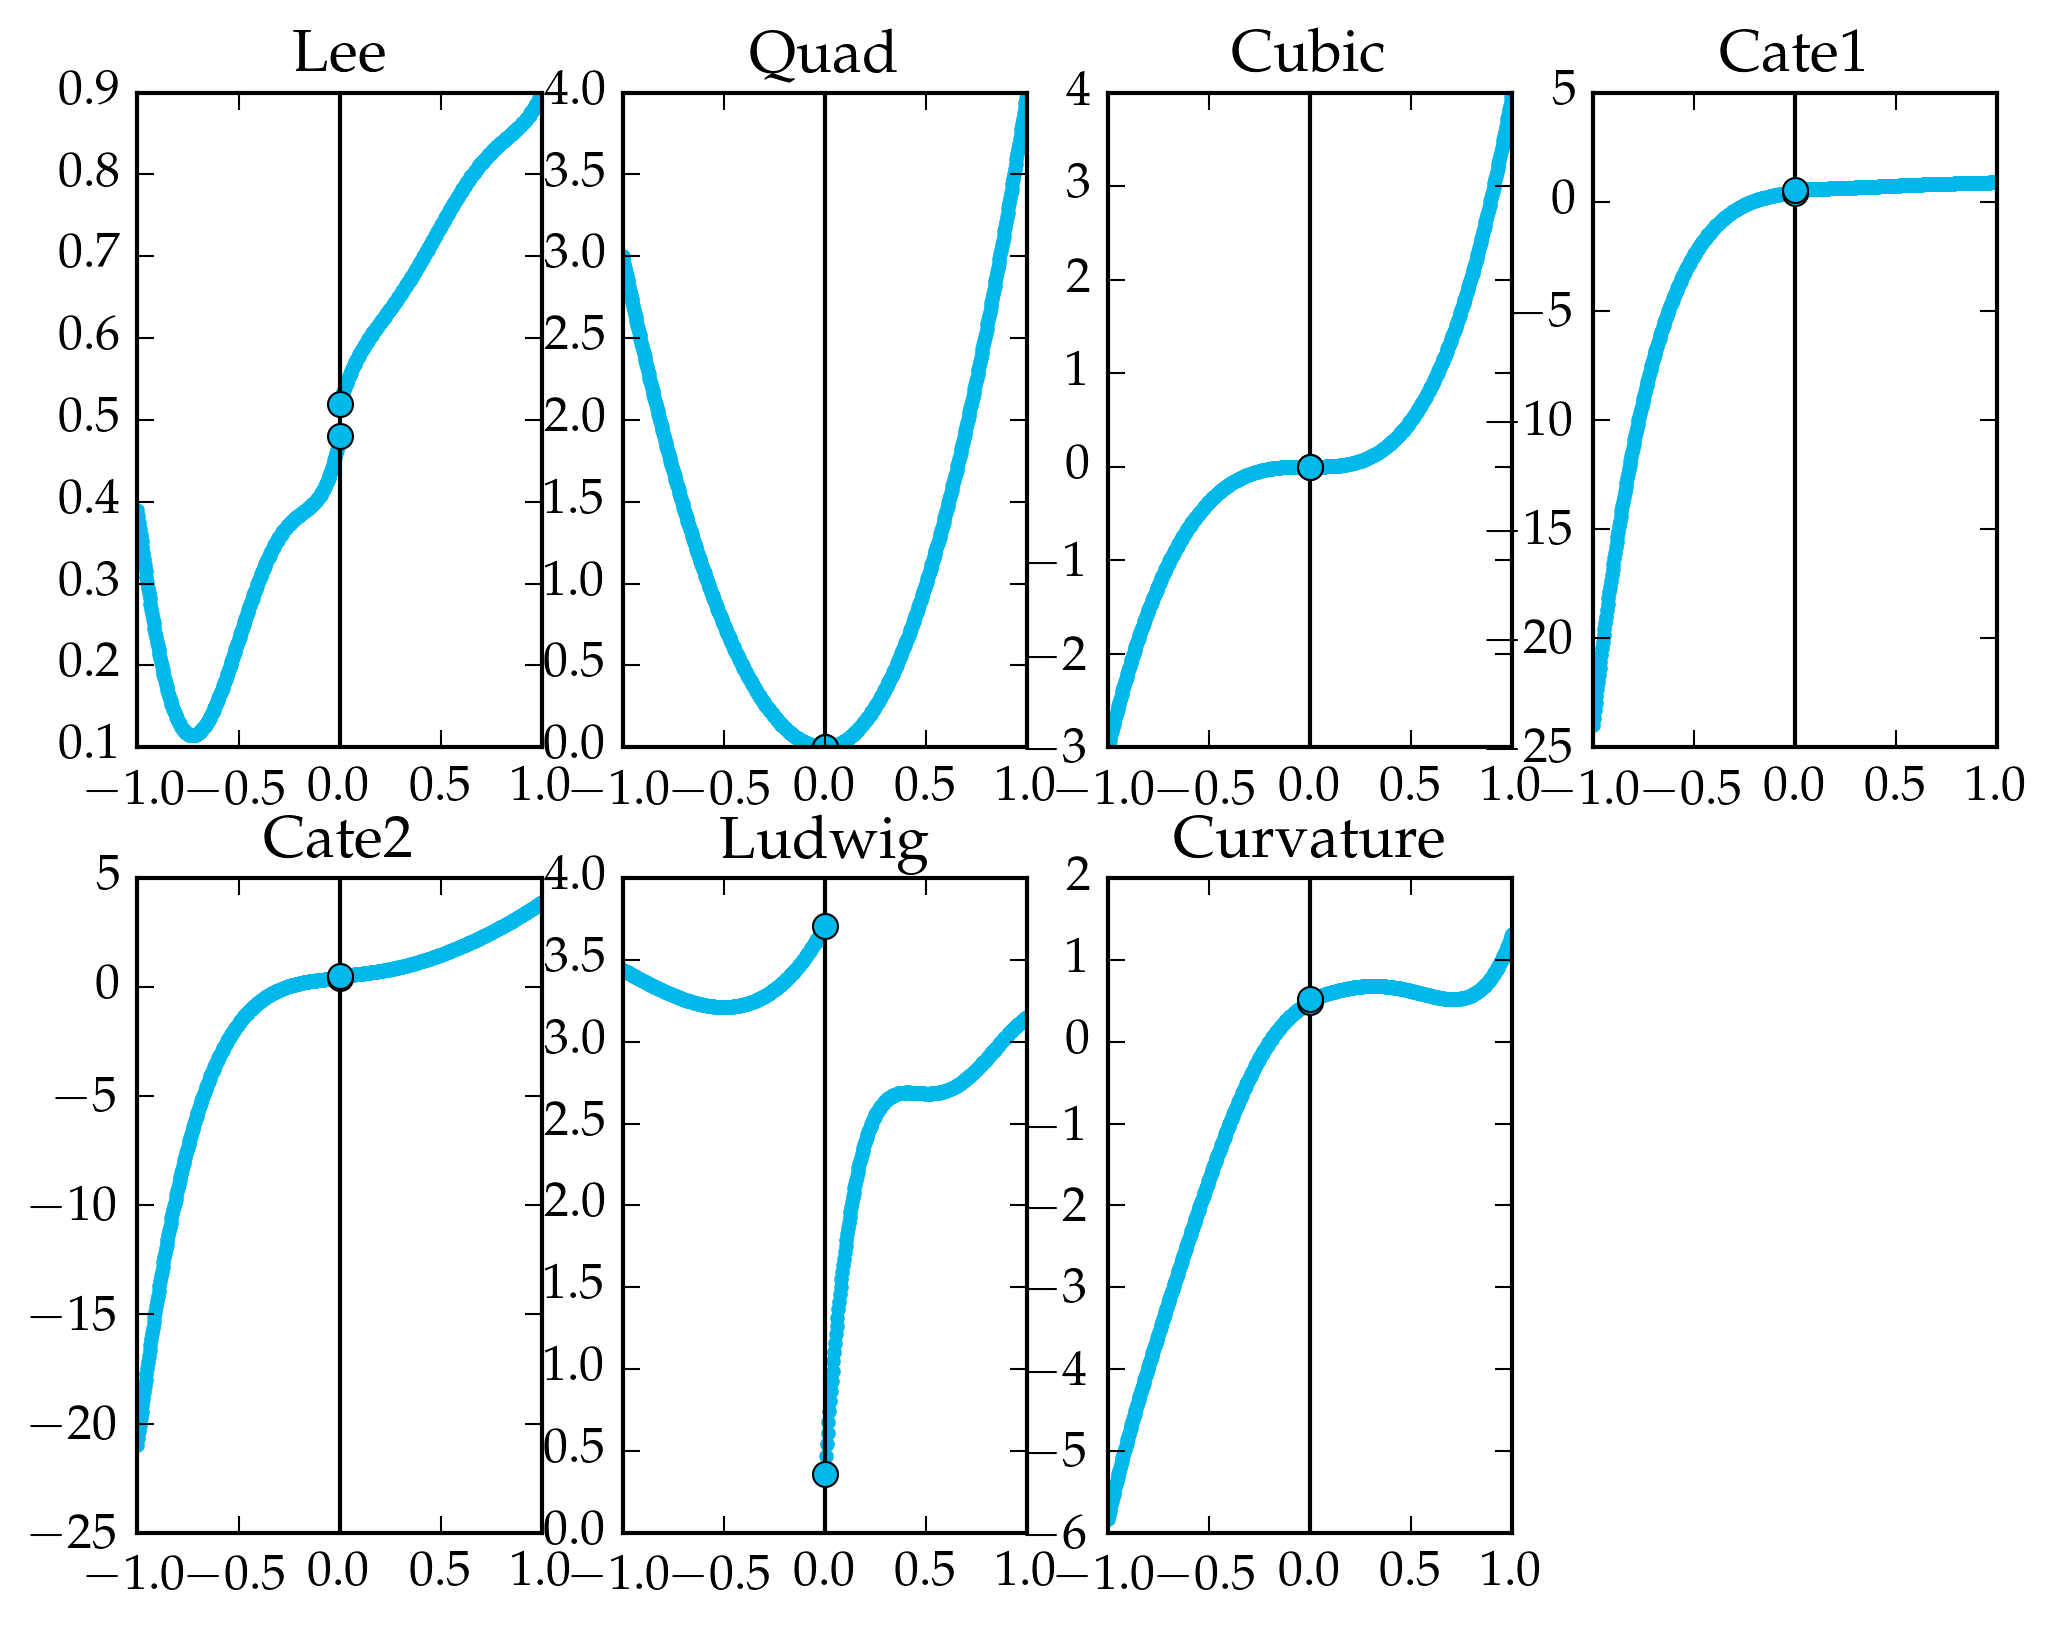

In [21]:
for (i,s) in enumerate(settings)
    plt.subplot(2,4,i)
    xx_left = xx[xx.<=0]
    xx_right = xx[xx.>=0]
    plt.plot(xx_left, s.left.(xx_left), ".", color="#00B8EA", linewidth=2, label="truth")
    plt.plot(xx_right, s.right.(xx_right), ".", color="#00B8EA", linewidth=2)
    plt.axvline(0.0, color="black")
    plt.plot(0.0, s.left(0.0), "o", color="#00B8EA")
    plt.plot(0.0, s.right(0.0), "o", color="#00B8EA")
    plt.title(s.name)
end 

In [22]:
type FittedResults
    setting::SimulationSetting
    centers_left::Vector{Float64}
    centers_right::Vector{Float64}
    fitted_kernels_left::Vector{Kernel}
    fitted_kernels_right::Vector{Kernel}
    fitted_hyperparams_left::Matrix{Float64}
    fitted_hyperparams_right::Matrix{Float64}
end

## code: sliding window

In [23]:
function inloop(i,left,right,truth,init_x,first,fitted_kernels,centers,fitted_hyper,fitmean,ngrid)
    if first
        grid_width=5.0
    else
        grid_width=2.0
    end
    fitted_k, fitted_x = window_hyperparams(left, right, 100, 
        truth,
        init_x;
        grid_width=grid_width,
        fitmean=fitmean,
        ngrid=ngrid
        )
    push!(fitted_kernels, fitted_k)
    push!(centers, (left+right)/2)
    fitted_hyper[i,:] = fitted_x
    init_x[:] = fitted_x
end

function sliding_kernel_fit(setting::SimulationSetting; fitmean::Bool=true, ngrid::Int=10)
    left_arr = collect(linspace(-1.0,0,99))
    width=0.2
    centers_l = Float64[]
    fitted_kernels_l = Kernel[]
    indexed_left_arr = collect(enumerate(left_arr))
    istart=searchsortedfirst(left_arr, -0.5)
    first=true
    init_init = [-1.0, -1.0]
    if fitmean
        init_init = [0.0, 0.0, -1.0, -1.0]
    end
    init_x = init_init
    
    fitted_hyper_l = Array(Float64, length(left_arr), length(init_x))
    for (i,left) in indexed_left_arr[istart:end]
        right = left+width
        if right > 0
            break
        end
        print(".")
        inloop(i,left,right,setting.left,init_x,first,fitted_kernels_l,centers_l,fitted_hyper_l,fitmean,ngrid)
        first = false
    end
    init_x = init_init
    first = true
    for (i,left) in indexed_left_arr[istart-1:-1:1]
        right = left+width
        if right > 0
            break
        end
        print(".")
        inloop(i,left,right,setting.left,init_x,first,fitted_kernels_l,centers_l,fitted_hyper_l,fitmean,ngrid)
        first = false
    end
    
    ### ABOVE DISCONTINUITY
    left_arr = collect(linspace(0.0,1.0,99))
    width=0.2
    centers_r = Float64[]
    fitted_kernels_r = Kernel[]
    indexed_left_arr = collect(enumerate(left_arr))
    istart=searchsortedfirst(left_arr,0.3)
    init_x = init_init
    first=true
    fitted_hyper_r = Array(Float64, length(left_arr), length(init_x))
    for (i,left) in indexed_left_arr[istart:end]
        right = left+width
        if right > 1.0
            break
        end
        print(".")
        inloop(i,left,right,setting.right,init_x,first,fitted_kernels_r,centers_r,fitted_hyper_r,fitmean,ngrid)
        first = false
    end
    init_x = init_init
    first=true
    for (i,left) in indexed_left_arr[istart-1:-1:1]
        right = left+width
        if right > 1.0
            break
        end
        print(".")
        inloop(i,left,right,setting.right,init_x,first,fitted_kernels_r,centers_r,fitted_hyper_r,fitmean,ngrid)
        first = false
    end
    order_l = sortperm(centers_l)
    order_r = sortperm(centers_r)
    return FittedResults(
        setting, 
        centers_l[order_l], 
        centers_r[order_r], 
        fitted_kernels_l[order_l], 
        fitted_kernels_r[order_r],
        fitted_hyper_l,
        fitted_hyper_r,
        )
end

sliding_kernel_fit (generic function with 1 method)

In [24]:
function plot_fitted_ℓ(fitted::FittedResults)
    plt.plot(fitted.centers_left, [√k.ℓ2 for k in fitted.fitted_kernels_left], linewidth=2)
    plt.plot(fitted.centers_right, [√k.ℓ2 for k in fitted.fitted_kernels_right], linewidth=2)
    plt.axvline(0.0, color="black")
    plt.ylabel(L"Estimated lengthscale $(\hat{\ell})$")
    plt.xlabel("Center of sliding window")
    plt.title(fitted.setting.name)
end

plot_fitted_ℓ (generic function with 1 method)

## doing it

In [25]:
@time fitted_all_nomean = [sliding_kernel_fit(setting;fitmean=false) for setting in settings];

..............................................................................................................................................................................................................................................................................................................................................................Base.LinAlg.PosDefException(3)
Base.LinAlg.PosDefException(3)
.Base.LinAlg.PosDefException(63)
.........................................Base.LinAlg.PosDefException(4)
.............................Base.LinAlg.PosDefException(3)
.Base.LinAlg.PosDefException(2)
.Base.LinAlg.PosDefException(18)
Base.LinAlg.PosDefException(2)
Base.LinAlg.PosDefException(18)
..Base.LinAlg.PosDefException(2)
Base.LinAlg.PosDefException(43)
Base.LinAlg.PosDefException(2)
Base.LinAlg.PosDefException(43)
.Base.LinAlg.PosDefException(2)
Base.LinAlg.PosDefException(5)
........................................................................................................

In [26]:
@time fitted_all_mean = [sliding_kernel_fit(setting;fitmean=true,ngrid=5) for setting in settings];

................................................................................Base.LinAlg.PosDefException(2)
........Base.LinAlg.PosDefException(2)
Base.LinAlg.PosDefException(4)
Base.LinAlg.PosDefException(2)
Base.LinAlg.PosDefException(3)
..Base.LinAlg.PosDefException(2)
.Base.LinAlg.PosDefException(3)
................................Base.LinAlg.PosDefException(38)
..Base.LinAlg.PosDefException(3)
.....Base.LinAlg.PosDefException(2)
.................Base.LinAlg.PosDefException(7)
Base.LinAlg.PosDefException(3)
..........................................................................................................................................................................Base.LinAlg.PosDefException(3)
........................................................................................................................................................................................................................Base.LinAlg.PosDefException(7)
.....................Base.LinAlg

..........Base.LinAlg.PosDefException(62)
.....Base.LinAlg.PosDefException(65)
...........Base.LinAlg.PosDefException(2)
Base.LinAlg.PosDefException(18)
........Base.LinAlg.PosDefException(3)
.................Base.LinAlg.PosDefException(4)
Base.LinAlg.PosDefException(2)
...........................................................................................Base.LinAlg.PosDefException(40)
........................Base.LinAlg.PosDefException(40)
..

................................................................................................................................................................................................................................................................................................................................................................................421.852370 seconds (366.34 M allocations: 14.111 GB, 0.63% gc time)


In [27]:
# plt.figure(figsize=(20,10))
# for (i,fitted) in enumerate(fitted_all)
#     plt.subplot(2,4,i)
#     plot_fitted_ℓ(fitted)
# end

# Plotting second derivatives

In [28]:
import ForwardDiff

In [29]:
import ForwardDiff
function second_deriv(x::Float64, setting::SimulationSetting)
    if x<0
        return ForwardDiff.hessian(xx -> setting.left(xx[1]), [x])[1]
    else
        return ForwardDiff.hessian(xx -> setting.right(xx[1]), [x])[1]
    end
end

second_deriv (generic function with 1 method)

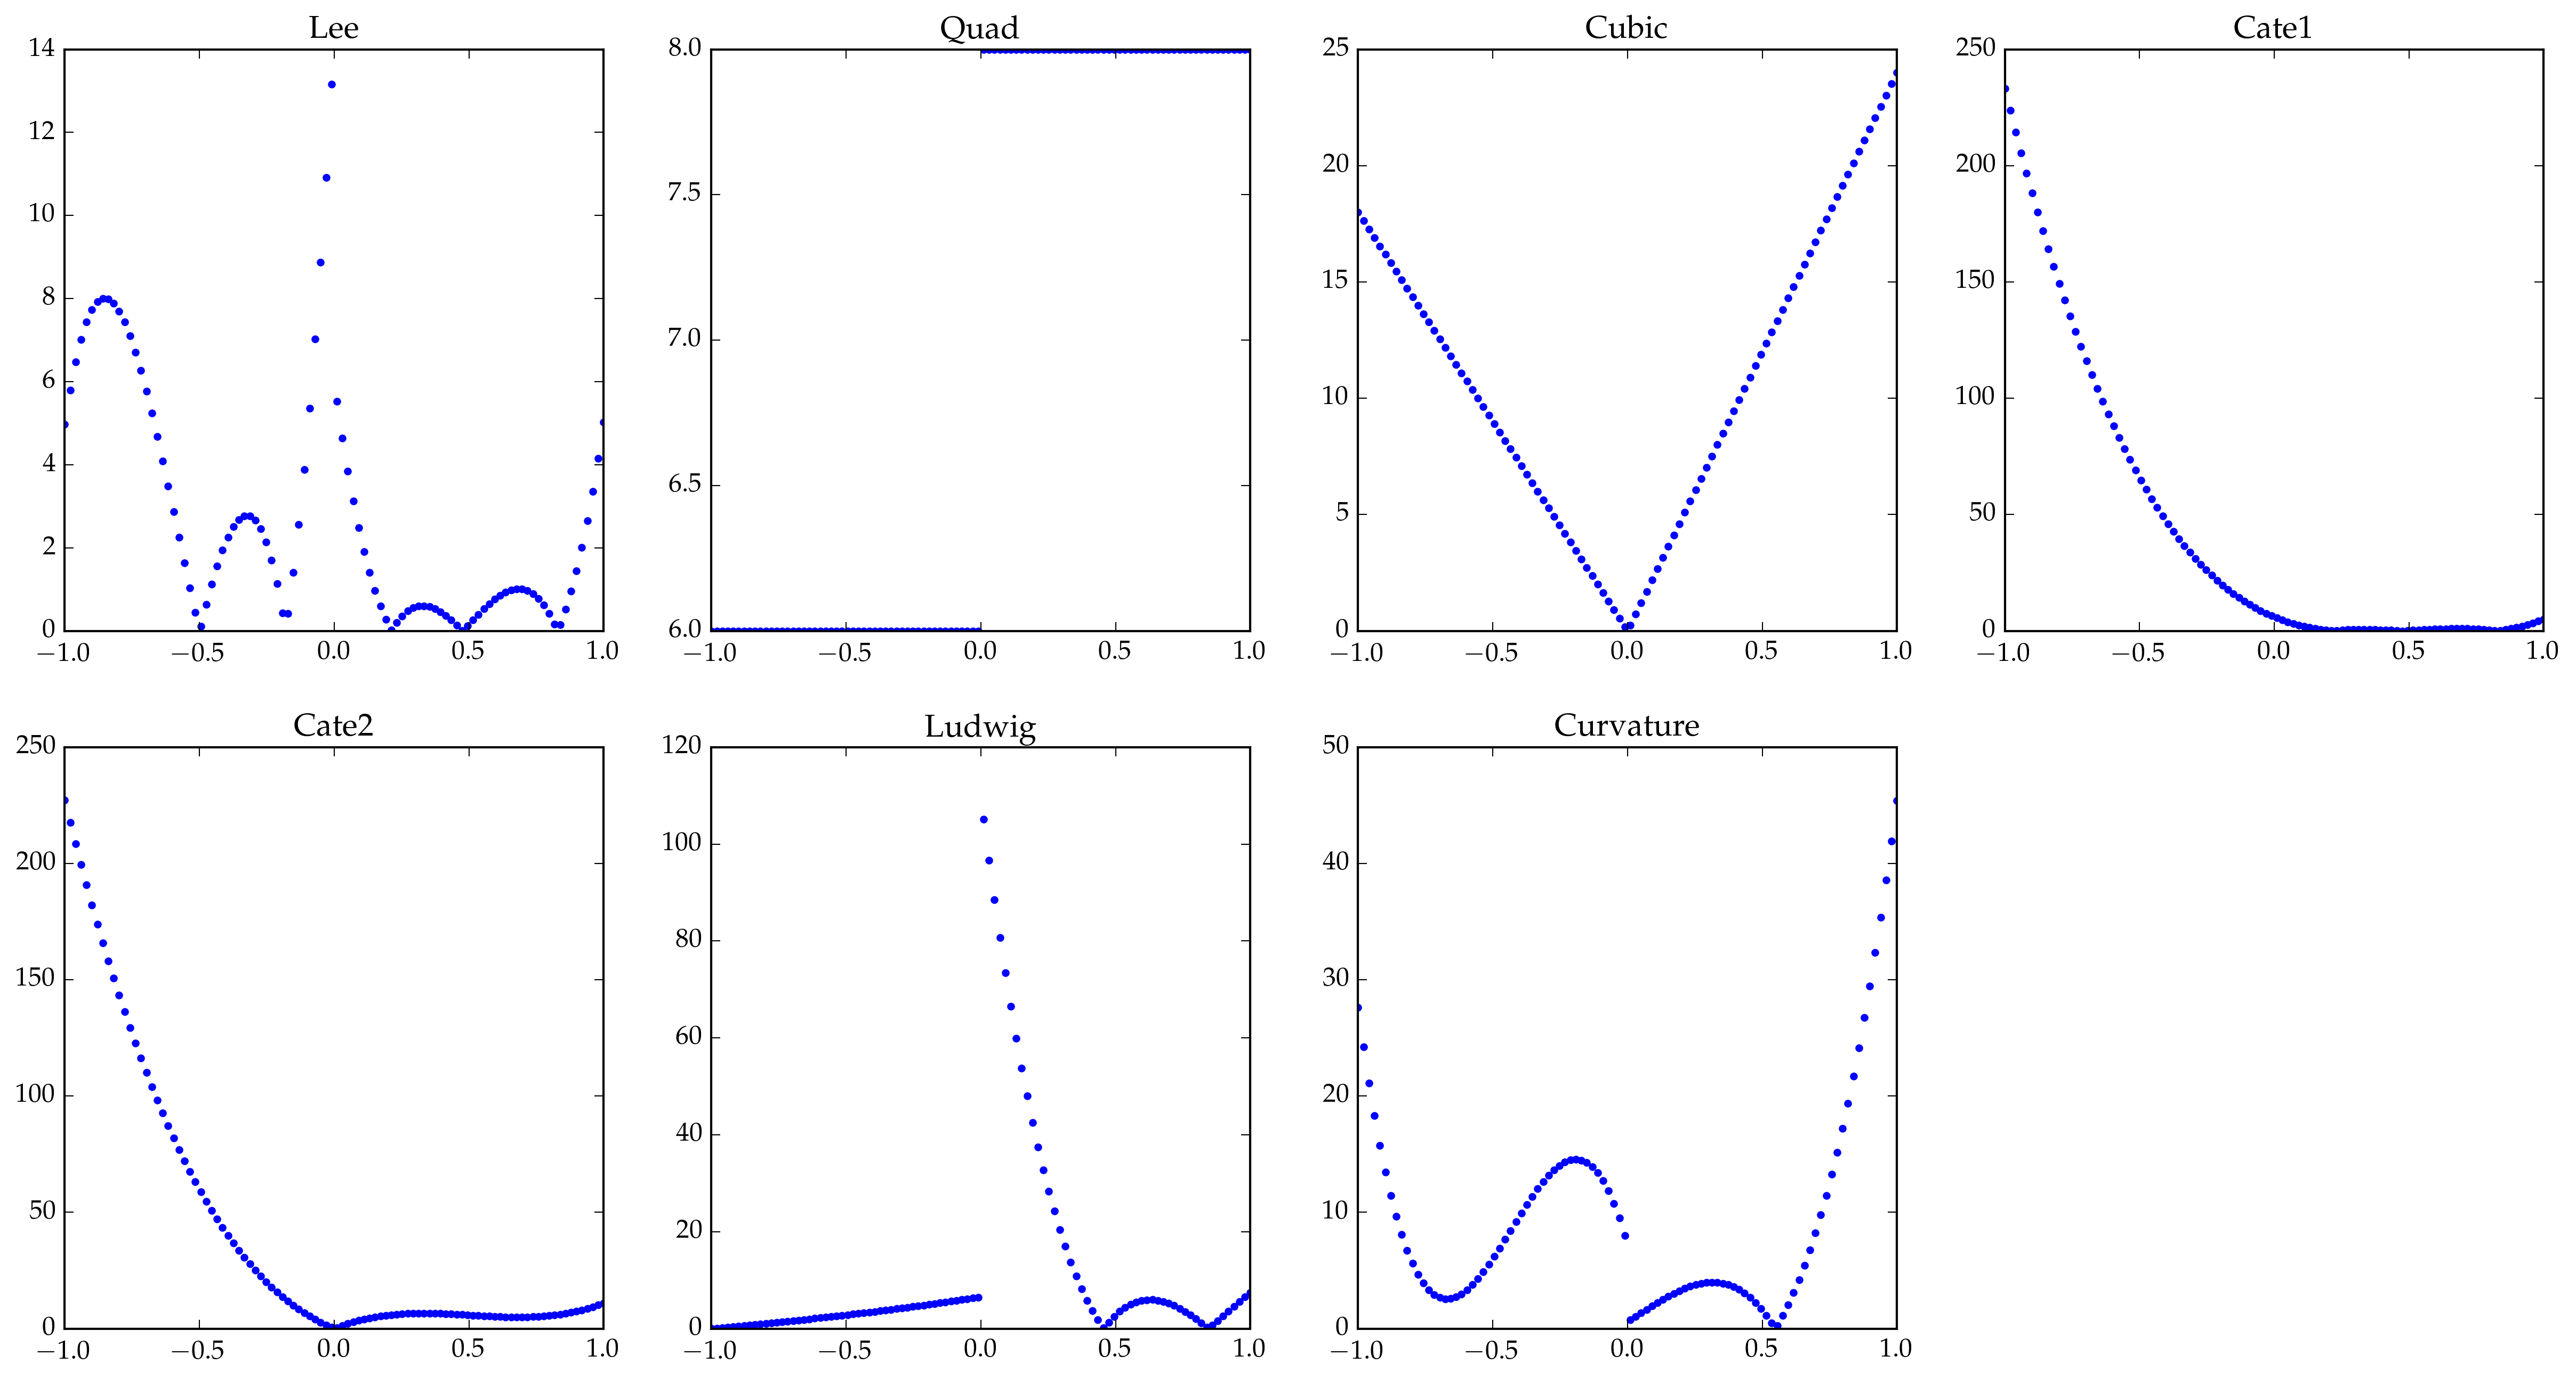

In [30]:
plt.figure(figsize=(20,10))
xx = linspace(-1,1,100)
for (i,setting) in enumerate(settings)
    plt.subplot(2,4,i)
    plt.plot(xx, [abs(second_deriv(x, setting)) for x in xx], ".")
    plt.title(setting.name)
#     plot_fitted_ℓ(fitted)
end

# Scatter Plot

“a scatterplot, where the horizontal axis is the absolute second derivative, and the vertical axis is $\hat{\ell}$. Then, if we plot a bunch of dots corresponding to a bunch of different values of X, we should see that the absolute second derivative and $\hat{\ell}$ are highly correlated, which is the idea we're trying to communicate.”

In [31]:
function scatter_ℓ_2nd(fitted::FittedResults; kwargs...)
    centers_left = fitted.centers_left
    ℓ_left = [√k.ℓ2 for k in fitted.fitted_kernels_left]
    left_2nd = [second_deriv(x, fitted.setting) for x in centers_left]
    plt.scatter(abs(left_2nd), ℓ_left; label=fitted.setting.name, kwargs...)
    
    centers_right = fitted.centers_right
    ℓ_right = [√k.ℓ2 for k in fitted.fitted_kernels_right]
    right_2nd = [second_deriv(x, fitted.setting) for x in centers_right]
    plt.scatter(abs(right_2nd), ℓ_right; kwargs...)
end

scatter_ℓ_2nd (generic function with 1 method)

In [32]:
# cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
# plt.figure(figsize=(20,10))
# for (i,fitted) in enumerate(fitted_all)
#     plt.subplot(2,4,i)
#     scatter_ℓ_2nd(fitted; color=cbbPalette[i])
#     plt.xlabel(L"|f\"(x)|")
#     plt.ylabel(L"$\hat{\ell}$")
#     plt.xlim(0,15)
#     plt.ylim(0,1.5)
#     plt.title(fitted.setting.name)
# end
# # plt.legend(loc="upper left")
# ;

# Merged plots

In [33]:
function plot_merged(fitted::FittedResults; kwargs...)
    centers_left = fitted.centers_left
    ℓ_left = [√k.ℓ2 for k in fitted.fitted_kernels_left]
    left_2nd = [second_deriv(x, fitted.setting) for x in centers_left]
    
    centers_right = fitted.centers_right
    ℓ_right = [√k.ℓ2 for k in fitted.fitted_kernels_right]
    right_2nd = [second_deriv(x, fitted.setting) for x in centers_right]
    
    plt.plot(centers_left, ℓ_left, 
        linewidth=2, color="#D55E00",
        label=L"$\hat{\ell}$"
        )
    plt.plot(centers_right, ℓ_right, 
        linewidth=2, color="#D55E00")
    plt.axvline(0.0, color="black")
    ax1 = plt.gca()
    plt.xlabel("Center of sliding window")
    plt.tick_params("y", colors="#D55E00")
    
    
    ax2 = ax1[:twinx]()
    plt.sca(ax2)
    plt.plot(centers_left, abs(left_2nd), 
        linewidth=3, linestyle="--", color="#0072B2",
        label=L"|f\"(x)|")
    plt.plot(centers_right, abs(right_2nd), 
        linewidth=3, linestyle="--", color="#0072B2")
    ylim = plt.ylim()
    plt.ylim(ylim[1], min(ylim[2],30.0))
    plt.tick_params("y", colors="#0072B2")
    return ax1, ax2
#     plt.plot(xx, [abs(second_deriv(x, setting)) for x in xx], ".")
end


plot_merged (generic function with 1 method)

In [34]:
function plot_σ(fitted::FittedResults; kwargs...)
    centers_left = fitted.centers_left
    σ_left = [√k.σ2 for k in fitted.fitted_kernels_left]
    left_2nd = [second_deriv(x, fitted.setting) for x in centers_left]
    
    centers_right = fitted.centers_right
    σ_right = [√k.σ2 for k in fitted.fitted_kernels_right]
    right_2nd = [second_deriv(x, fitted.setting) for x in centers_right]
    
    plt.plot(centers_left, σ_left, 
        linewidth=2, color="#D55E00",
        label=L"$\hat{\sigma_{GP}}$"
        )
    plt.plot(centers_right, σ_right, 
        linewidth=2, color="#D55E00")
    plt.axvline(0.0, color="black")
    ax1 = plt.gca()
    plt.xlabel("Center of sliding window")
    plt.tick_params("y", colors="#D55E00")
    
    
    ax2 = ax1[:twinx]()
    plt.sca(ax2)
    plt.plot(centers_left, abs(left_2nd), 
        linewidth=3, linestyle="--", color="#0072B2",
        label=L"|f\"(x)|")
    plt.plot(centers_right, abs(right_2nd), 
        linewidth=3, linestyle="--", color="#0072B2")
    plt.tick_params("y", colors="#0072B2")
    return ax1, ax2
#     plt.plot(xx, [abs(second_deriv(x, setting)) for x in xx], ".")
end


plot_σ (generic function with 1 method)

In [35]:
function plot_σℓ(fitted::FittedResults; kwargs...)
    centers_left = fitted.centers_left
    σ_left = [√k.σ2 for k in fitted.fitted_kernels_left]
    ℓ_left = [√k.ℓ2 for k in fitted.fitted_kernels_left]
    left_2nd = [second_deriv(x, fitted.setting) for x in centers_left]
    
    centers_right = fitted.centers_right
    σ_right = [√k.σ2 for k in fitted.fitted_kernels_right]
    ℓ_right = [√k.ℓ2 for k in fitted.fitted_kernels_right]
    right_2nd = [second_deriv(x, fitted.setting) for x in centers_right]
    
    y_left =   σ_left ./  ℓ_left.^(1)
    y_right = σ_right ./ ℓ_right.^(1)
    plt.plot(centers_left, y_left, 
        linewidth=2, color="#D55E00",
        label=L"$\hat{\sigma}_{GP}/\hat{\ell}$"
        )
    plt.plot(centers_right, y_right, 
        linewidth=2, color="#D55E00")
    plt.axvline(0.0, color="black")
    ax1 = plt.gca()
    plt.xlabel("Center of sliding window")
    plt.tick_params("y", colors="#D55E00")
    
    ax2 = ax1[:twinx]()
    plt.sca(ax2)
    plt.plot(centers_left, abs(left_2nd), 
        linewidth=3, linestyle="--", color="#0072B2",
        label=L"|f\"(x)|")
    plt.plot(centers_right, abs(right_2nd), 
        linewidth=3, linestyle="--", color="#0072B2")
    plt.tick_params("y", colors="#0072B2")
    
    lr_2nd = [abs(left_2nd) ; abs(right_2nd)]
    lr_ratio = [y_left ; y_right]
    argsort_2nd = sortperm(lr_2nd)
    i10 = searchsortedlast(lr_2nd[argsort_2nd],10.0)
    i10_2nd = lr_2nd[argsort_2nd][i10]
    i10_ratio = lr_ratio[argsort_2nd][i10]
    calibration_ratio = i10_ratio / i10_2nd
    
    ylim2 = plt.ylim()
    plt.ylim(0.0, min(max(ylim2[2], maximum(lr_2nd)*1.1),30.0))
    ylim2 = plt.ylim()
    
    plt.sca(ax1)
    plt.ylim(0.0, ylim2[2]*calibration_ratio)

    return ax1, ax2
#     plt.plot(xx, [abs(second_deriv(x, setting)) for x in xx], ".")
end

plot_σℓ (generic function with 1 method)

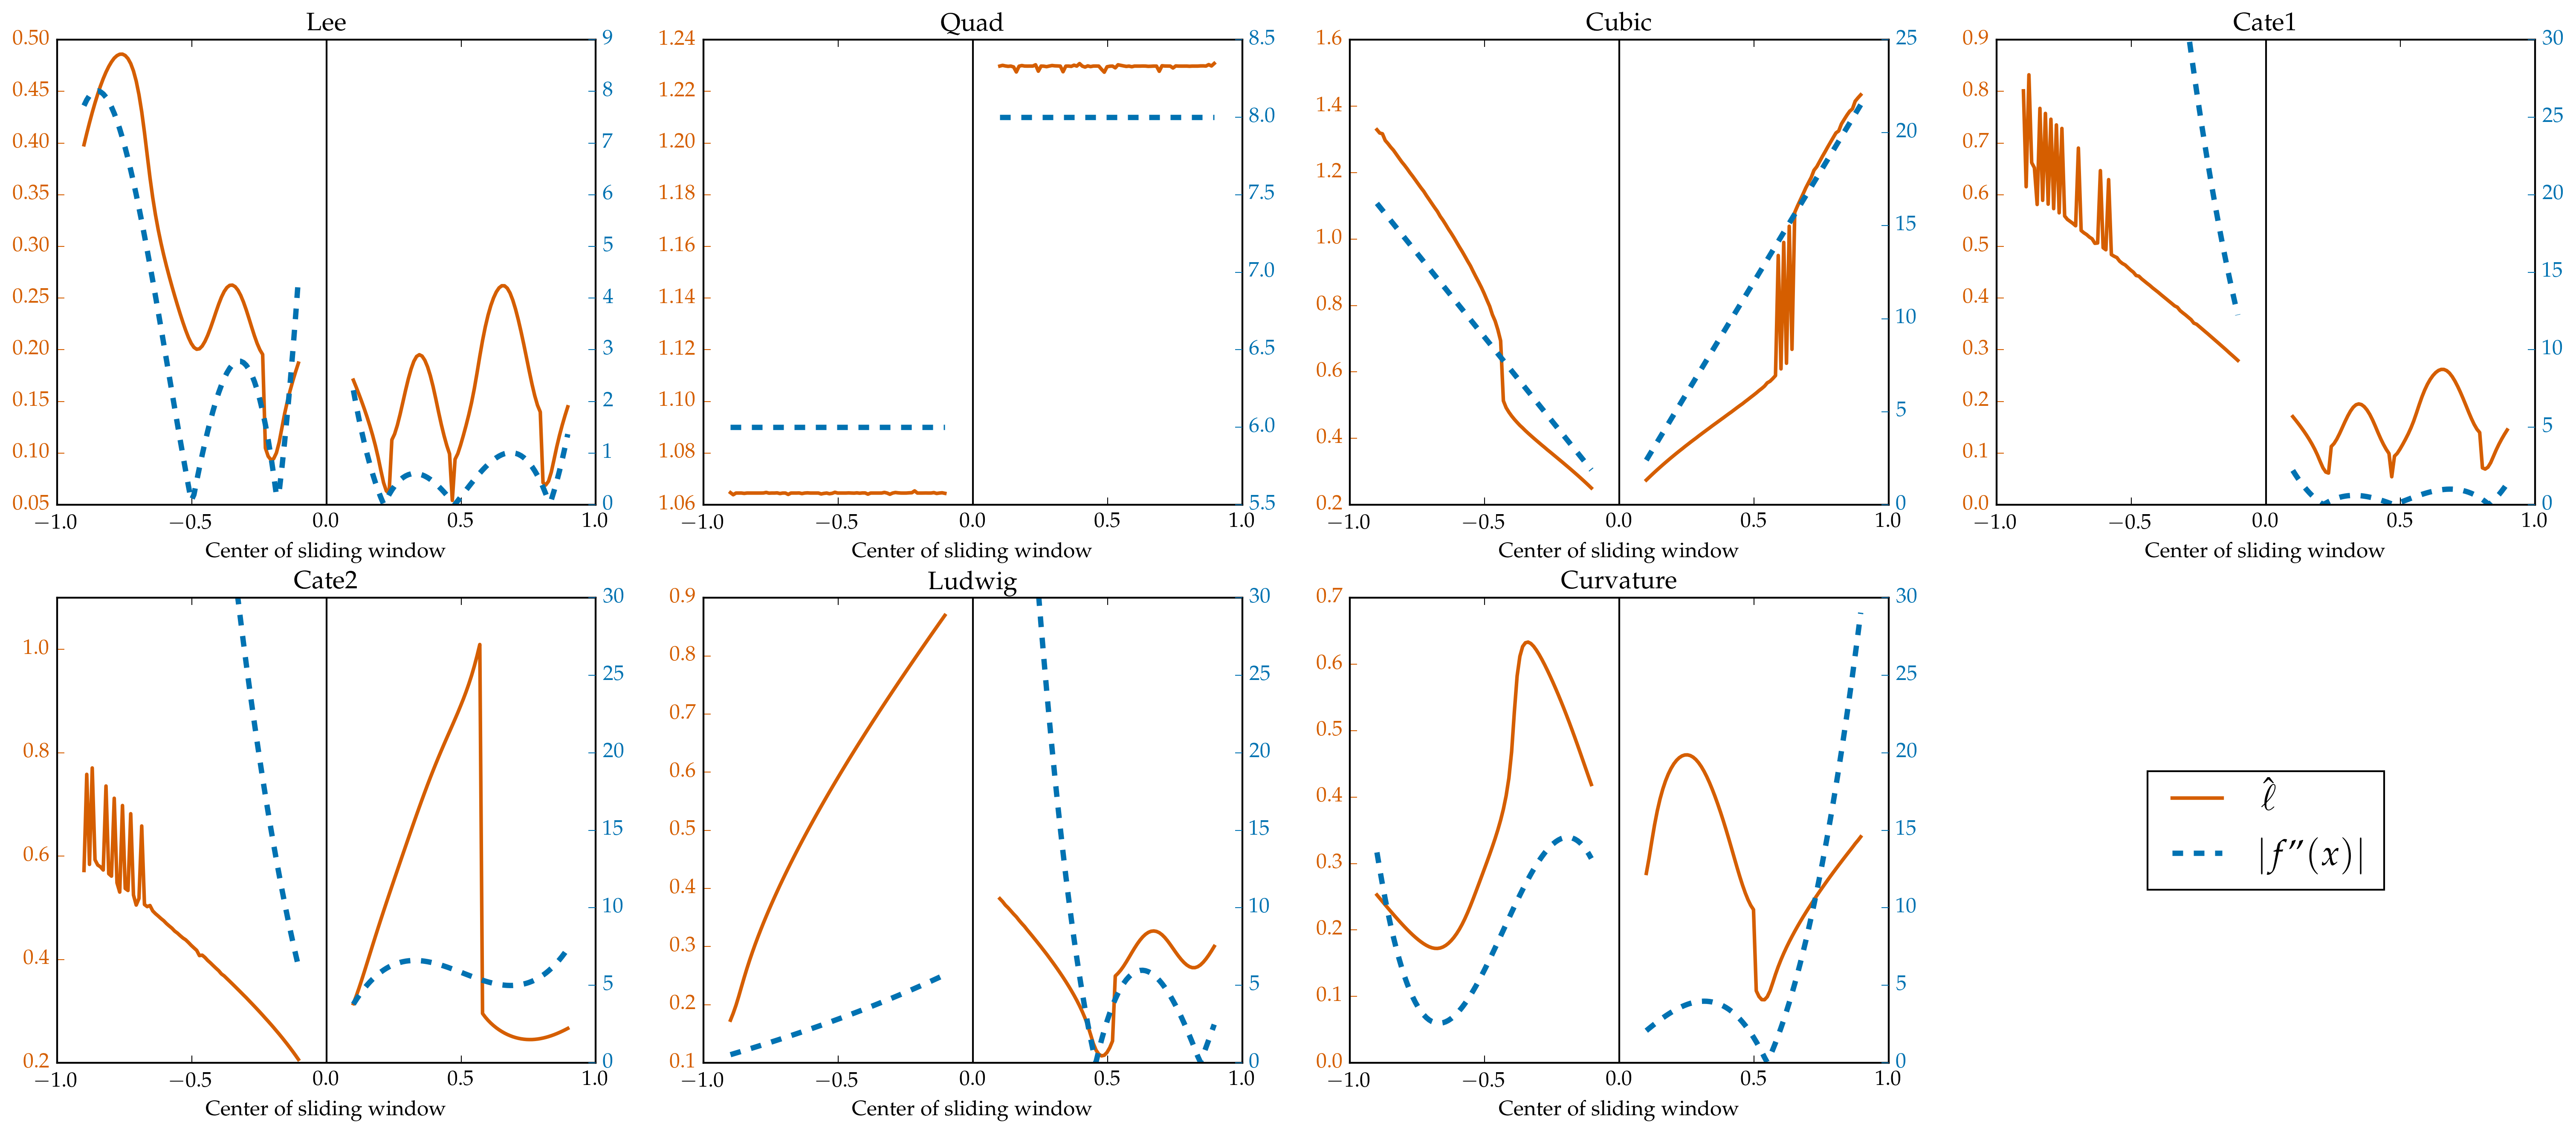

In [56]:
plt.figure(figsize=(25,10))
ax1 = plt.gca()
ax2 = plt.gca()
for (i,fitted) in enumerate(fitted_all_nomean)
    plt.subplot(2,4,i)
    ax1, ax2 = plot_merged(fitted)
    plt.title(fitted.setting.name)
    if i==2
        plt.ylim(5.5, 8.5)
    end
end
h1, l1 = ax1[:get_legend_handles_labels]()
h2, l2 = ax2[:get_legend_handles_labels]()
plt.subplot(2,4,8)
plt.gca()[:axis]("off")
plt.legend([h1;h2],[l1;l2],loc="center", fontsize=20)
;

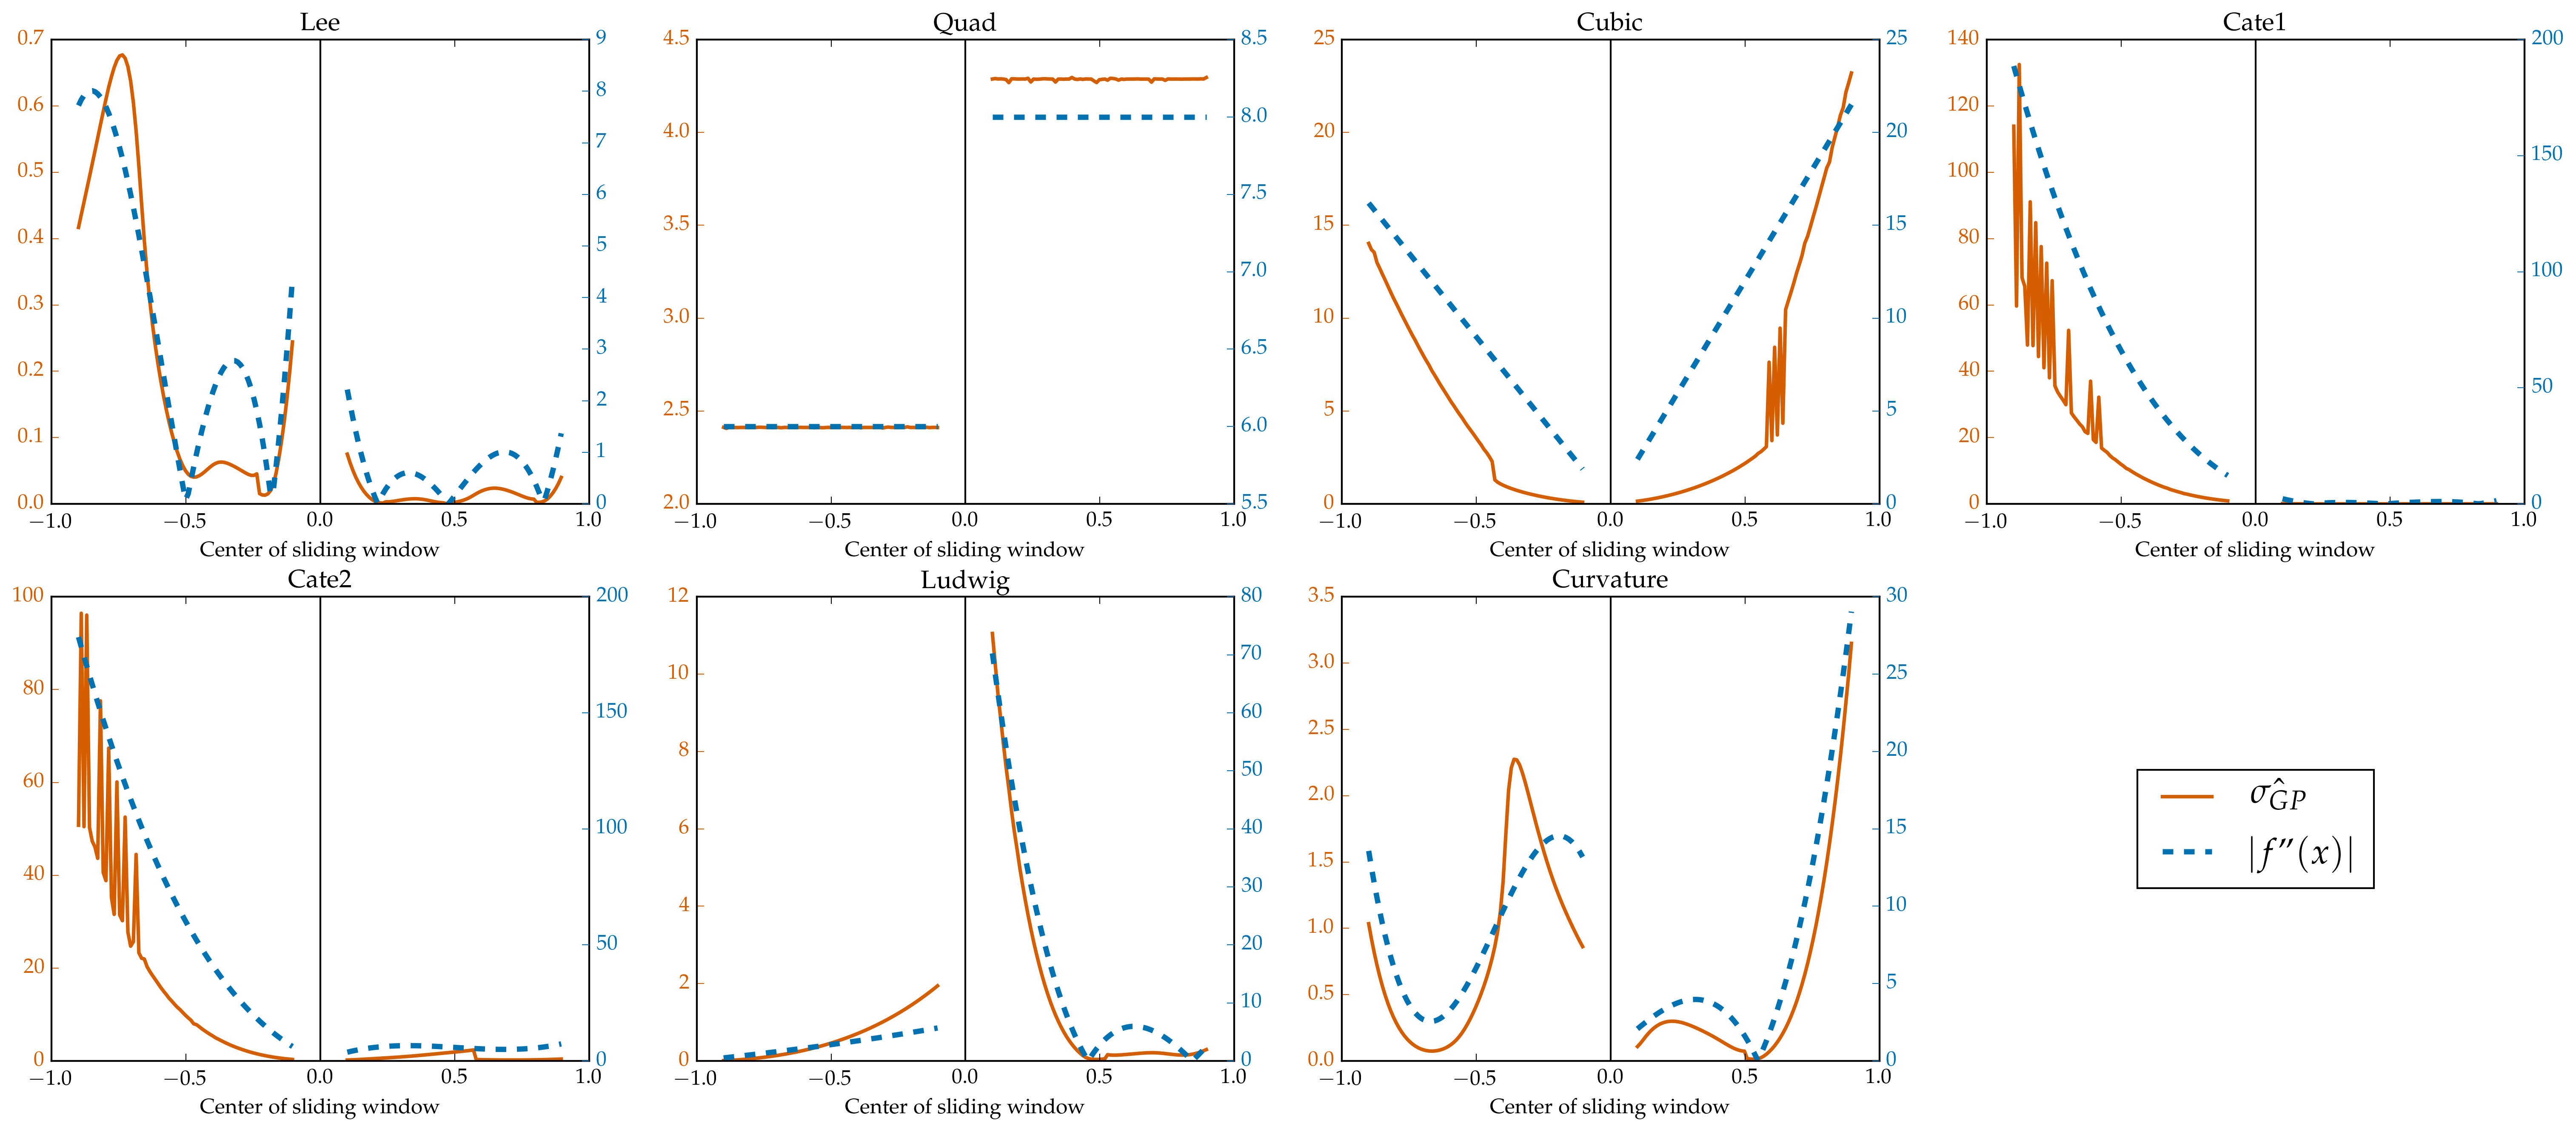

In [57]:
plt.figure(figsize=(25,10))
ax1 = plt.gca()
ax2 = plt.gca()
for (i,fitted) in enumerate(fitted_all_nomean)
    plt.subplot(2,4,i)
    ax1, ax2 = plot_σ(fitted)
    plt.title(fitted.setting.name)
    if i==2
        plt.ylim(5.5, 8.5)
    end
end
h1, l1 = ax1[:get_legend_handles_labels]()
h2, l2 = ax2[:get_legend_handles_labels]()
plt.subplot(2,4,8)
plt.gca()[:axis]("off")
plt.legend([h1;h2],[l1;l2],loc="center", fontsize=20)

;

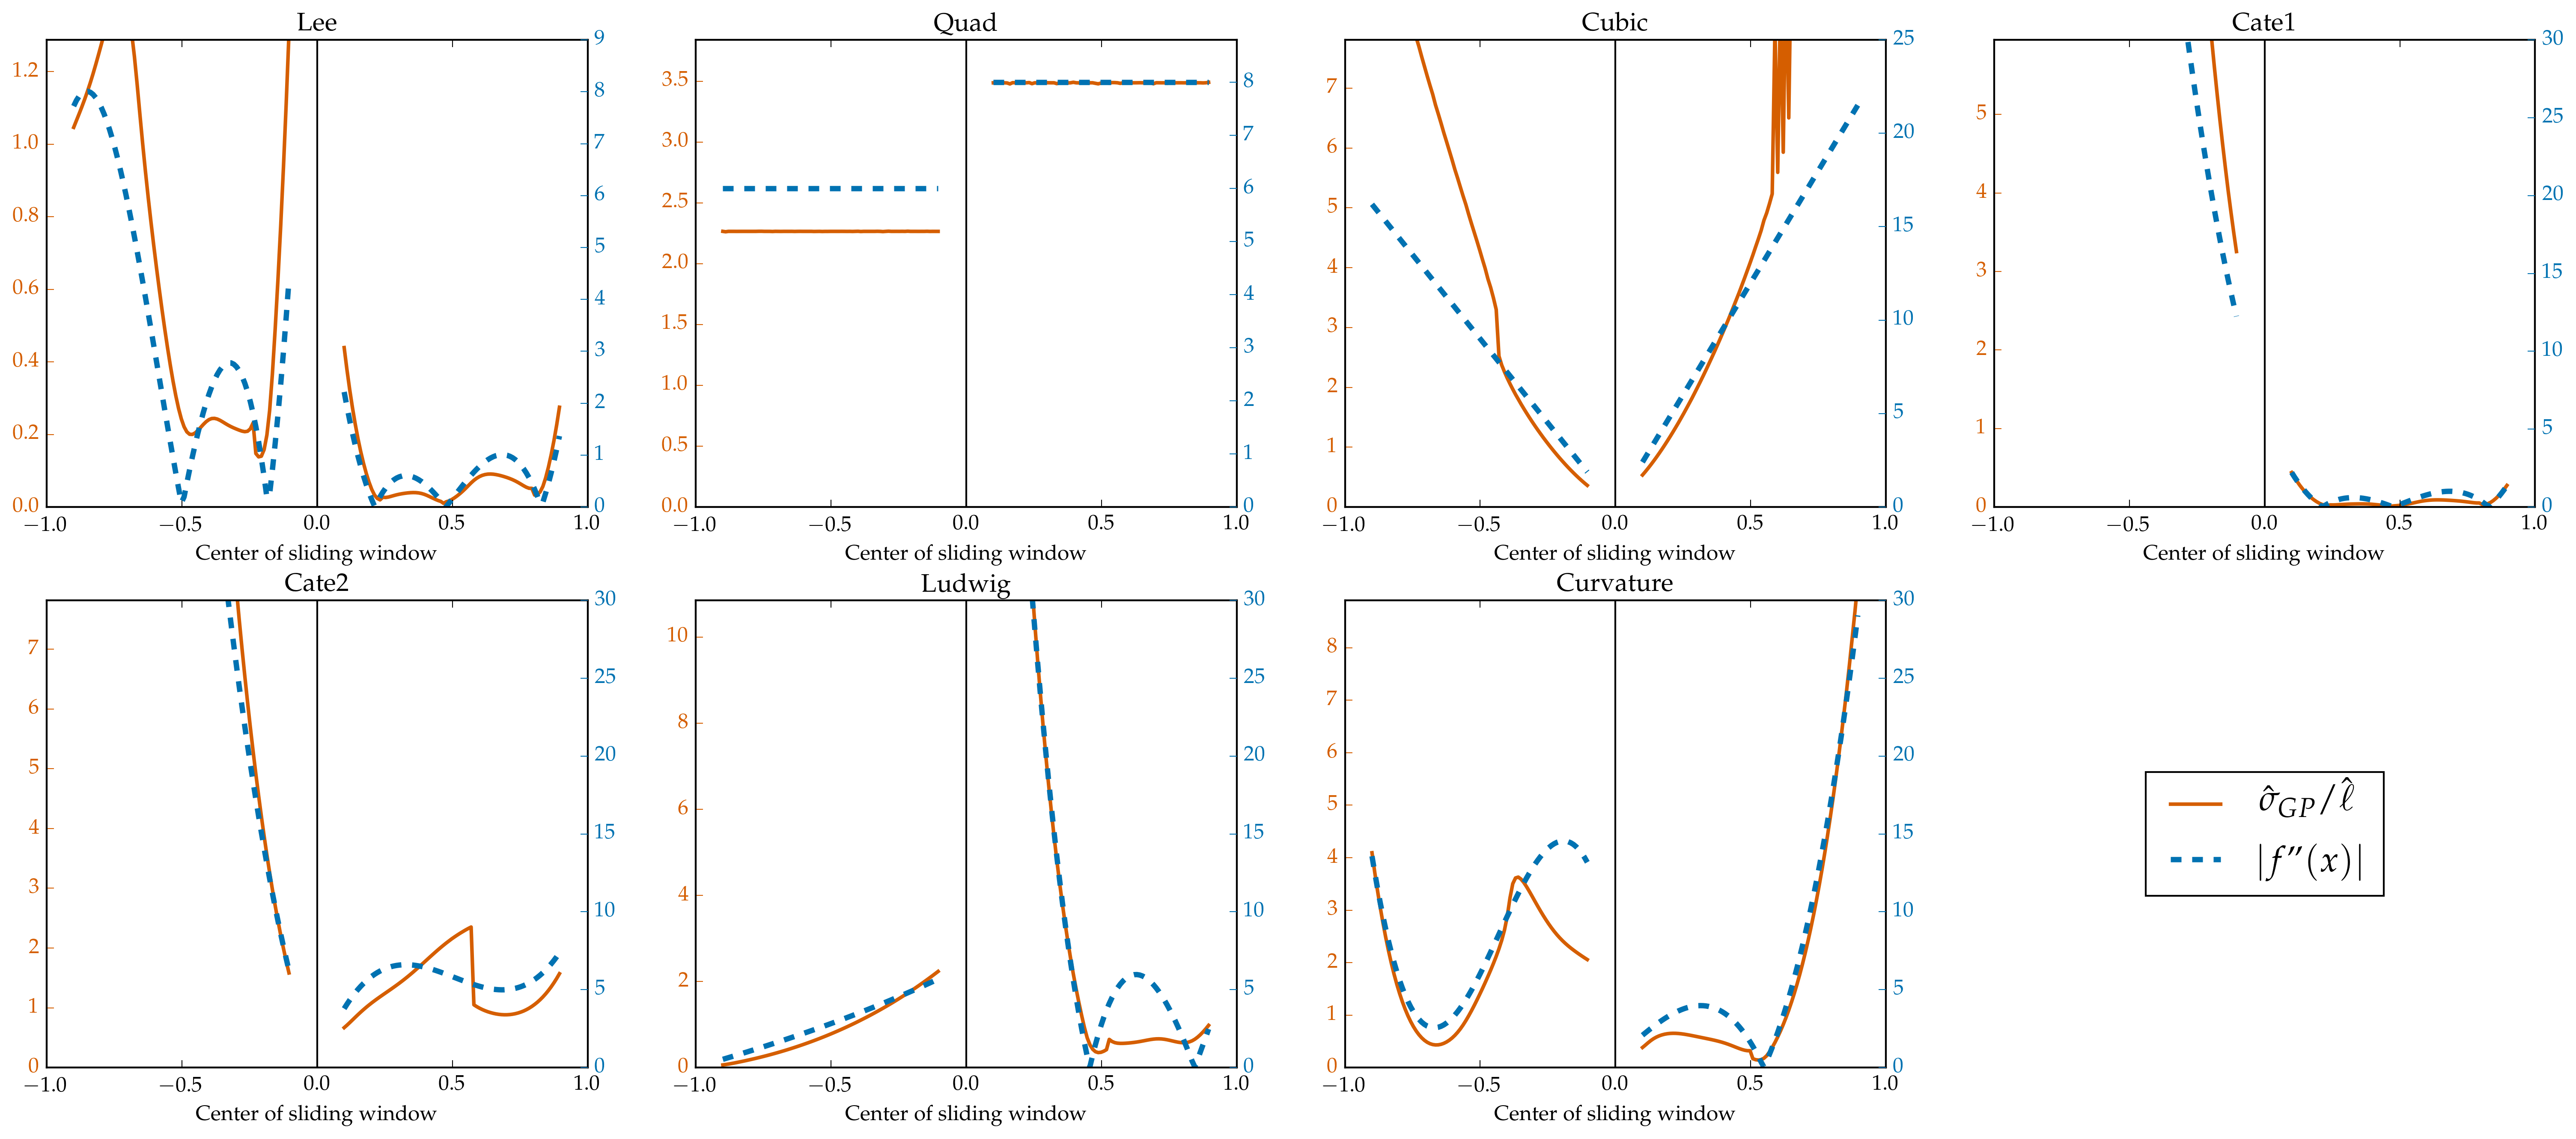

In [55]:
plt.figure(figsize=(25,10))
ax1 = plt.gca()
ax2 = plt.gca()
for (i,fitted) in enumerate(fitted_all_nomean)
    plt.subplot(2,4,i)
    ax1, ax2 = plot_σℓ(fitted)
    plt.title(fitted.setting.name)
end
h1, l1 = ax1[:get_legend_handles_labels]()
h2, l2 = ax2[:get_legend_handles_labels]()
plt.subplot(2,4,8)
plt.gca()[:axis]("off")
plt.legend([h1;h2],[l1;l2],loc="center", fontsize=20)
;

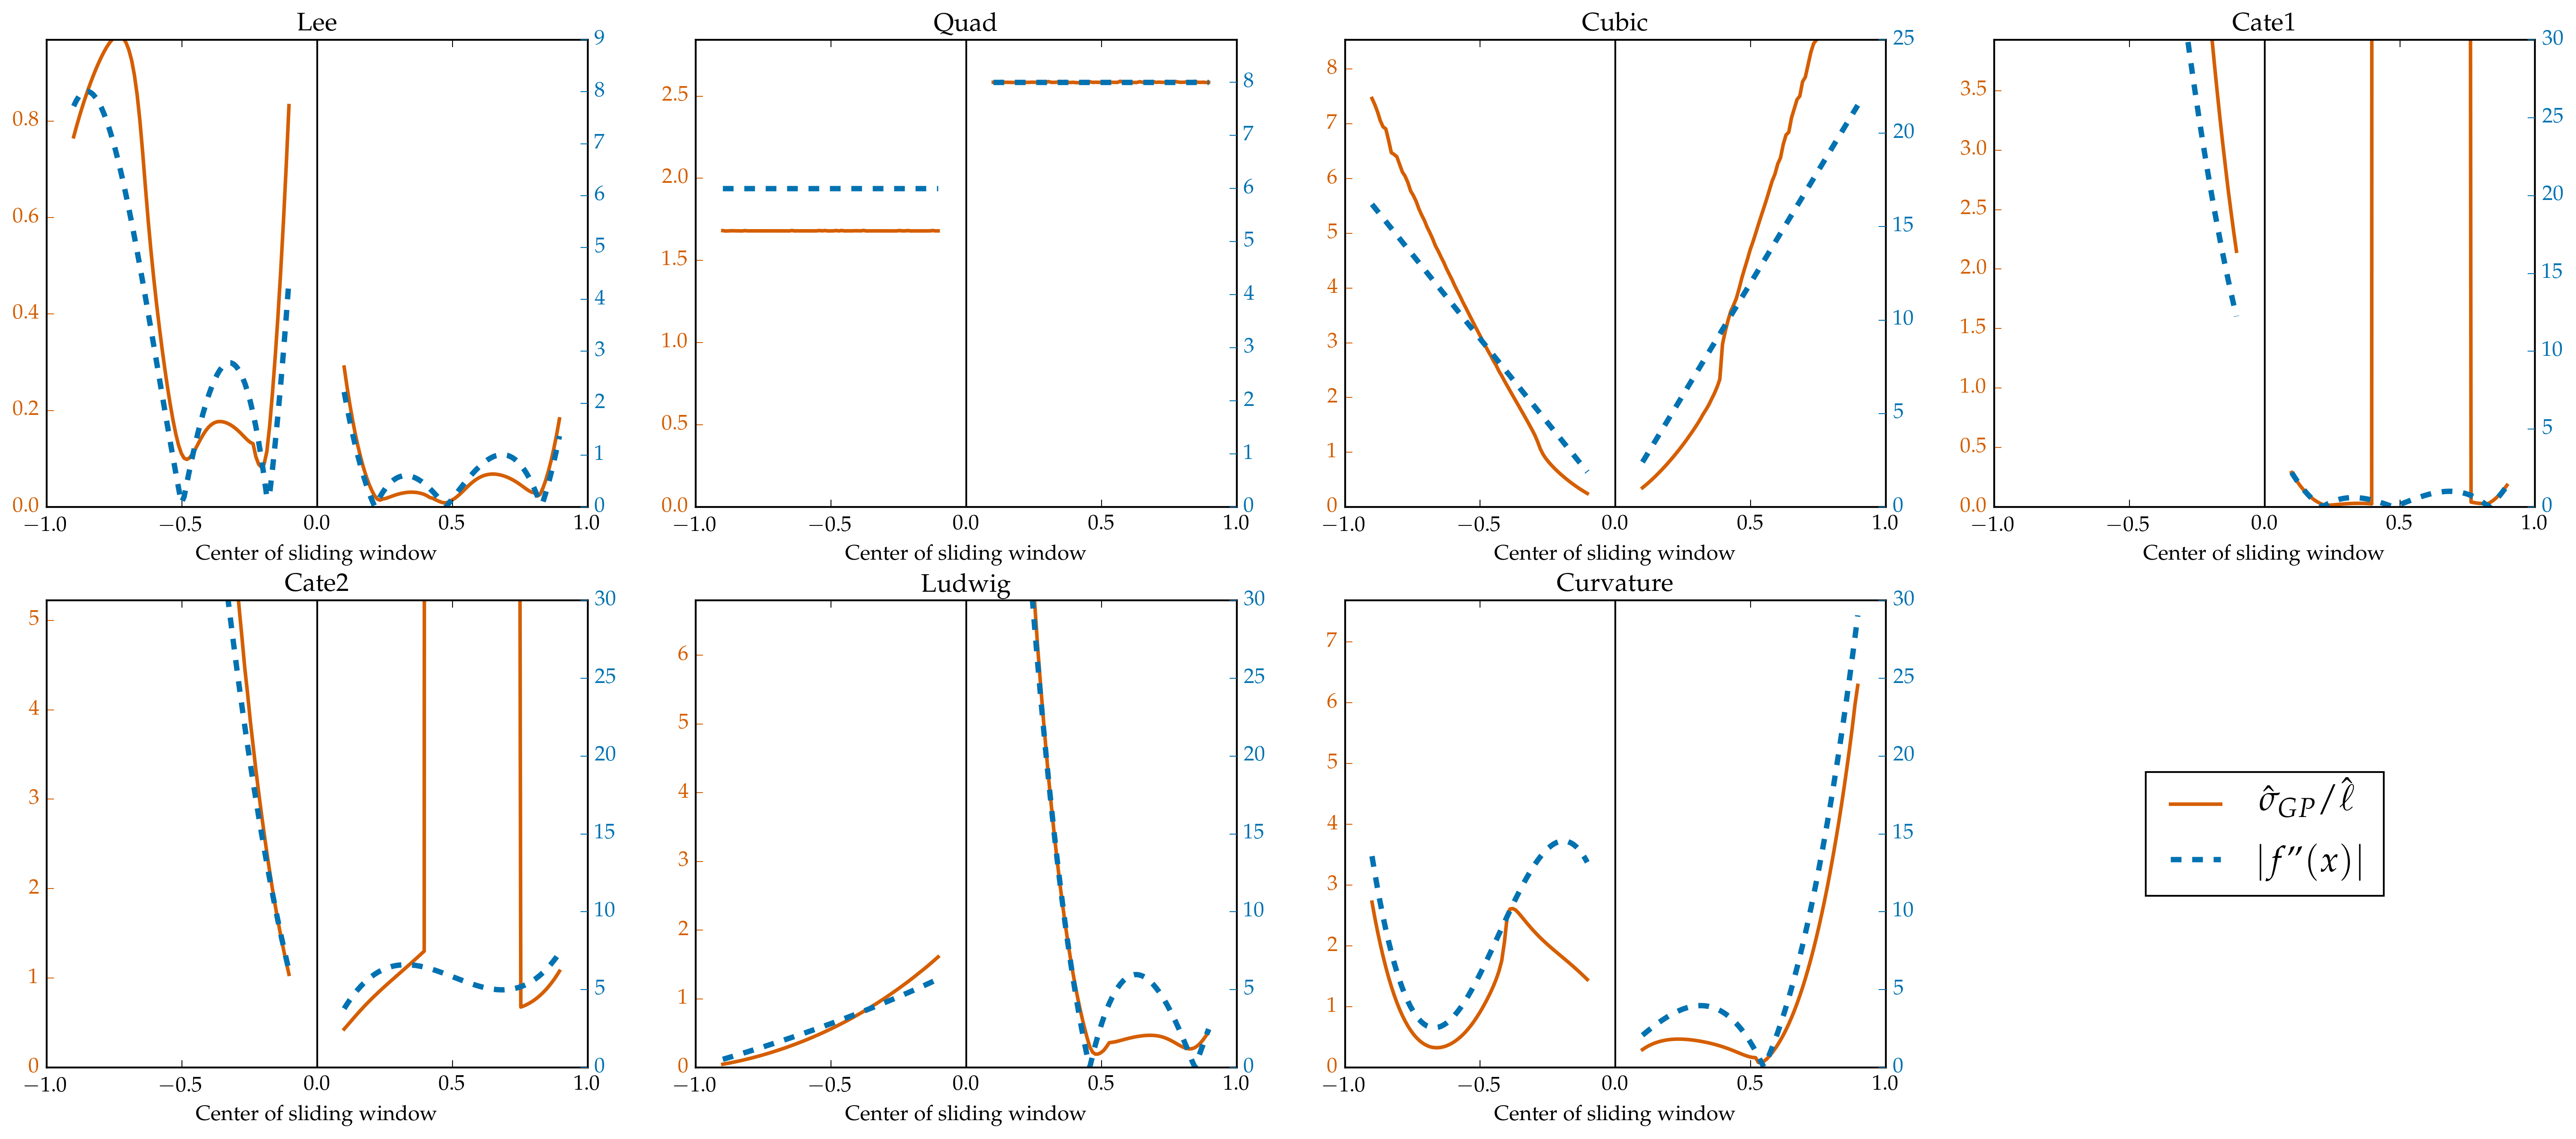

In [52]:
plt.figure(figsize=(25,10))
ax1 = plt.gca()
ax2 = plt.gca()
for (i,fitted) in enumerate(fitted_all_mean)
    plt.subplot(2,4,i)
    ax1, ax2 = plot_σℓ(fitted)
    plt.title(fitted.setting.name)
end
h1, l1 = ax1[:get_legend_handles_labels]()
h2, l2 = ax2[:get_legend_handles_labels]()
plt.subplot(2,4,8)
plt.gca()[:axis]("off")
plt.legend([h1;h2],[l1;l2],loc="center", fontsize=20)
;

# understanding drop in $\sigma/\ell$ in Cate2

In [40]:
function eval_hyperparams(lower::Float64, upper::Float64, npoints::Int, 
        truth::Function, 
        init_x::Vector{Float64})
    x=collect(linspace(lower,upper,npoints))
    y=truth.(x)
    x.-=mean(x)
    y.-=mean(y)
    β0,β1=linreg(x,y)
#     @printf("β0: %.5f, β1: %.5f\n", β0, β1)
    meanf = MeanLin([β1])+MeanConst(β0)
    logNoise = log(1e-8)
    kern = SEIso(0.0,0.0)
    gp = GP(x', y, meanf, kern, logNoise)
    set_params!(gp, init_x, mean=false, kern=true, noise=false)
    GaussianProcesses.update_mll!(gp)
    return gp.mLL
end

eval_hyperparams (generic function with 1 method)

In [41]:
settings[5].name

"Cate2"

## plotting mLL surface

In [42]:
function plot_mLL_surface(iwindow)
    f=fitted_all[5]
    parwindow = iwindow
    iwindow = iwindow
    width = 0.2
    center = f.centers_right[iwindow]
    lower = center - width/2
    upper = center + width/2
    hyper = f.fitted_hyperparams_right[parwindow,:]
    kern = f.fitted_kernels_right[parwindow]
    truth = f.setting.right
    @printf("setting: %s\n", f.setting.name)
    @printf("center: %.2f\n", center)
    @printf("using parameters from center: %.2f\n", f.centers_right[parwindow])
    println("kernel parameters: ", get_params(kern))
    @printf("σ/ℓ: %.5f\n", √(kern.σ2/kern.ℓ2))
    nσ = 100
    nℓ = 100
    lℓ_hat, lσ_hat = get_params(kern)
    lσ_arr = linspace(lσ_hat-4.0, lσ_hat+4.0, nσ)
    lℓ_arr = linspace(lℓ_hat-4.0, lℓ_hat+4.0, nℓ)
    mLL_grid = Array(Float64,nσ,nℓ)
    for (iσ,lσ) in enumerate(lσ_arr)
        for (iℓ,lℓ) in enumerate(lℓ_arr)
            hyper[1] = lℓ
            hyper[2] = lσ
            mLL = eval_hyperparams(lower, upper, 100, truth, hyper)
            mLL_grid[iσ,iℓ] = mLL
        end
    end
    mLL_max = maximum(mLL_grid)
    plt.imshow(mLL_grid;
        vmin=mLL_max-5.0, 
        vmax=mLL_max, 
        origin="lower",
        extent=[minimum(lℓ_arr),maximum(lℓ_arr),minimum(lσ_arr),maximum(lσ_arr)]
        )
    plt.colorbar()
    xlim = plt.xlim()
    ylim = plt.ylim()
    plt.plot((lℓ_hat-10,lℓ_hat+10),(lσ_hat-30,lσ_hat+30),color="black",linestyle=":")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(L"$\log(\ell)$")
    plt.ylabel(L"$\log(\sigma)$")
    plt.title(@sprintf("log-likelihood, window centered at %.3f", center))
end

plot_mLL_surface (generic function with 1 method)

In [43]:
plot_mLL_surface(40)

LoadError: UndefVarError: fitted_all not defined

In [44]:
plot_mLL_surface(47)

LoadError: UndefVarError: fitted_all not defined

In [45]:
plot_mLL_surface(48)

LoadError: UndefVarError: fitted_all not defined

In [46]:
plot_mLL_surface(55)

LoadError: UndefVarError: fitted_all not defined

## printing some mLL diagnostics

In [47]:
function print_mLL(iwindow,parwindow)
    f=fitted_all[5]
    width = 0.2
    center = f.centers_right[iwindow]
    lower = center - width/2
    upper = center + width/2
    hyper = f.fitted_hyperparams_right[parwindow,:]
    kern = f.fitted_kernels_right[parwindow]
    truth = f.setting.right
    @printf("setting: %s\n", f.setting.name)
    @printf("center: %.2f\n", center)
    @printf("using parameters from center: %.2f\n", f.centers_right[parwindow])
    @printf("σ/ℓ: %.5f\n", √(kern.σ2/kern.ℓ2))
    println("hyperparameters: ", hyper)
    mLL = eval_hyperparams(lower, upper, 100, truth, hyper)
    @printf("mLL: %.5f\n", mLL) 
end

print_mLL (generic function with 1 method)

In [48]:
print_mLL(47,47)

LoadError: UndefVarError: fitted_all not defined

In [49]:
print_mLL(47,48)

LoadError: UndefVarError: fitted_all not defined

In [50]:
print_mLL(48,47)

LoadError: UndefVarError: fitted_all not defined

In [51]:
print_mLL(48,48)

LoadError: UndefVarError: fitted_all not defined

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Fine-tune-optimization-so-it-works-in-edge-cases" data-toc-modified-id="Fine-tune-optimization-so-it-works-in-edge-cases-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fine-tune optimization so it works in edge cases</a></div><div class="lev2 toc-item"><a href="#estimating-hyperparameters" data-toc-modified-id="estimating-hyperparameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>estimating hyperparameters</a></div><div class="lev1 toc-item"><a href="#Example:-Lee" data-toc-modified-id="Example:-Lee-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example: Lee</a></div><div class="lev1 toc-item"><a href="#Iterate-over-simulation-settings" data-toc-modified-id="Iterate-over-simulation-settings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Iterate over simulation settings</a></div><div class="lev2 toc-item"><a href="#code:-sliding-window" data-toc-modified-id="code:-sliding-window-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>code: sliding window</a></div><div class="lev2 toc-item"><a href="#doing-it" data-toc-modified-id="doing-it-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>doing it</a></div><div class="lev1 toc-item"><a href="#Plotting-second-derivatives" data-toc-modified-id="Plotting-second-derivatives-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plotting second derivatives</a></div><div class="lev1 toc-item"><a href="#Scatter-Plot" data-toc-modified-id="Scatter-Plot-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scatter Plot</a></div><div class="lev1 toc-item"><a href="#Merged-plots" data-toc-modified-id="Merged-plots-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Merged plots</a></div><div class="lev1 toc-item"><a href="#understanding-drop-in-$\sigma/\ell$-in-Cate2" data-toc-modified-id="understanding-drop-in-$\sigma/\ell$-in-Cate2-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>understanding drop in $\sigma/\ell$ in Cate2</a></div><div class="lev2 toc-item"><a href="#plotting-mLL-surface" data-toc-modified-id="plotting-mLL-surface-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>plotting mLL surface</a></div><div class="lev2 toc-item"><a href="#printing-some-mLL-diagnostics" data-toc-modified-id="printing-some-mLL-diagnostics-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>printing some mLL diagnostics</a></div>